In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale, bands, topological_gap, sides
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [4]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    # {"device": {"thickness": {"dielectric": 1.0}}},
    {"device":
     {"grid_spacing":
      {"twoDEG": 0.5, "normal": 1, "dielectric": 1, "air": 5, "gate": 1, "substrate": 1}}},
    {"gate": {"channel_width": 13.0, "L":40, 'angle': np.pi/6, 'gap': 4}},
    # {"kwant": {'nww': 8}}
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [5]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:27<00:00,  2.13s/it]


In [10]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])/scale

### Initial voltage guess

[[-17.5   4.5]
 [-15.    8.5]
 [-12.5  13. ]
 [-10.   17.5]
 [ -7.5  21.5]
 [ -5.   26. ]
 [ -2.5  30.5]
 [  0.   34.5]]
[[17.5  4.5]
 [15.   8.5]
 [12.5 13. ]
 [10.  17.5]
 [ 7.5 21.5]
 [ 5.  26. ]
 [ 2.5 30.5]
 [ 0.  34.5]]
[[ 0. 70.]
 [ 0. 65.]
 [ 0. 60.]
 [ 0. 55.]
 [ 0. 50.]
 [ 0. 45.]
 [ 0. 40.]
 [ 0. 35.]]
[[-19.5  23.5]]
[[-6.   6.5]]
[[6.  6.5]]
[[19.5 23.5]]
[[-16.  57.]]
[[16. 57.]]


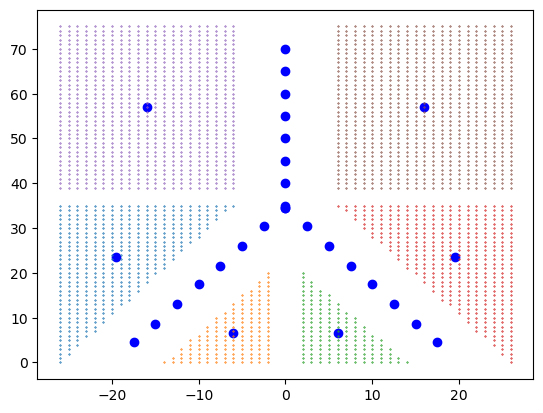

In [11]:
site_coords = system.grid_points[system.site_indices]
for gate, index in system.indices.items():
    point = kwant_sites[index]
    plt.scatter(point[:, 0], point[:, 1], c='b')
    print(point)


for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value] 

        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

#### Optimize potential shape

In [28]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [29]:
# optimal_voltages = {}
# optimal_phase = {}
for pair in ['left-right']:
    
#     params = parameters.junction_parameters()
#     params.update(potential=system.flat_potential())
    
#     index = system.indices.copy()

#     # remove 50% of the points from the channel to be depleted that is closest to the center.
#     depleted_channel = list(set(sides)-set(pair.split('-')))[0]
#     depleted_indices = index[depleted_channel]
#     index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]
    
#     params['dep_acc_index'] = index
    
#     args = (pair.split('-'),
#             (system.base_ham, system.linear_terms),
#             params['dep_acc_index'], 
#             )

#     initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

#     sol1 = minimize(codes.optimization.shape_loss, 
#              x0=initial_condition, 
#              args=args, 
#              method='trust-constr', 
#              options={'initial_tr_radius':1e-3}
#             )

#     print(sol1.x)

#     ci, weights = 50, [1, 1e1]
#     args = ((system.base_ham, 
#             params, 
#             system.linear_terms, 
#             system.f_params, 
#              system.mlwf[order_wavefunctions(pair)]),
#             (pair.split('-'), ci, wf_amp)
#            )
       
#     sol2 = minimize(codes.optimization.wavefunction_loss, 
#              x0=sol1.x, 
#              args=args, 
#              method='trust-constr',
#              options={
#                  'initial_tr_radius':1e-3,
#                  'verbose':2,
#              }
#             )

#     print(sol2.x)

#     params.update(parameters.voltage_dict(sol2.x))
    
#     args = (pair, 
#             params, 
#             (system.trijunction, system.linear_terms, 
#              system.f_params,
#              system.mlwf[order_wavefunctions(pair)]
#             )
#            )

#     sol3 = minimize_scalar(codes.optimization.loss, 
#                              args=args, 
#                              method='bounded', 
#                              bounds=(0,2)
#                           )

    
#     optimal_phase[pair] = sol3.x * np.pi
    
#     print(optimal_phase[pair])

#     params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    
#     base_ham = system.trijunction.hamiltonian_submatrix(
#         sparse=True, params=system.f_params(**params)
#     )

    args = (pair, 
            params, 
            (base_ham, system.linear_terms, 
             system.f_params,
             system.mlwf[order_wavefunctions(pair)]
            ),
           )
    
    sol4 = minimize(codes.optimization.loss, 
             x0=sol2.x, 
             args=args, 
             method='trust-constr', 
             options={
                 'initial_tr_radius':1e-3,
                 'verbose':2,
             }
            )
    
    optimal_voltages[pair] = parameters.voltage_dict(sol4.x)
        
    
    print(optimal_voltages[pair])

[-0.00117278 -0.00117278 -0.00596243  0.00314074]
0.06275131895590287 0.001102936967636906


KeyError: 'dep_acc_index'

#### Results

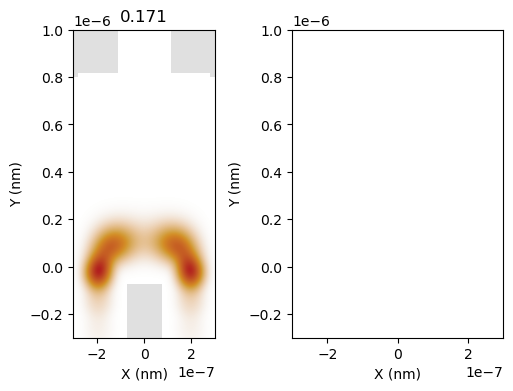

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 4))

for i, pair in enumerate(['left-right']):
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    params.update(parameters.voltage_dict([-0.00058147,
                                           -0.00058213,
                                           -0.01380494,
                                           0.00311198]))
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    linear_ham, full_ham = hamiltonian(base_ham, 
                                       system.linear_terms, 
                                       **params
                                      )

    

    evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

    transformed_hamiltonian = svd_transformation(
        evals, evecs, system.mlwf[order_wavefunctions(pair)]
    )

    desired = np.abs(transformed_hamiltonian[0, 1])
    undesired = np.linalg.norm(transformed_hamiltonian[2:])
    
    wfv = codes.optimization.density(evecs[:, 0])
    
    # potential = linear_ham.diagonal()[::4]
    # step_potential = np.array(np.abs(potential) > bands[0], dtype=int)
    # kwant.plotter.map(system.trijunction, lambda i: step_potential[i], ax=ax[0])
    kwant.plotter.density(system.trijunction, wfv, ax = ax[i]);
    ax[i].set_title(np.round(desired/topological_gap, 3))
    # for value in system.indices.values():
    #     ax[0].scatter(*kwant_sites[value], c='blue')
    
    # voltages = list(optimal_voltages[pair].values())
    # print(pair + ':', np.array(voltages)[list(range(0, 7, 2))])
for axes in ax:
    axes.set_ylim(-3e-7, 10e-7)
    axes.set_xlim(-3e-7, 3e-7)
    axes.set_xlabel('X (nm)')
    axes.set_ylabel('Y (nm)')
    
# fig.tight_layout()
# plt.savefig('/home/tinkerer/trijunction-design/codes/wavefunction.pdf', format='pdf')

#### Shape loss

In [53]:
import codes.optimization
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [54]:
pair  = 'right-top'

params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

index = system.indices.copy()

# remove 50% of the points from the channel to be depleted that is closest to the center.
depleted_channel = list(set(sides)-set(pair.split('-')))[0]
depleted_indices = index[depleted_channel]
index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]

params['dep_acc_index'] = index

args = (pair.split('-'),
        (system.base_ham, system.linear_terms),
        params['dep_acc_index'], 
        )

initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

sol1 = minimize(codes.optimization.shape_loss, 
         x0=initial_condition, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3}
        )

In [55]:
sol1.x

array([-0.00396824, -0.00313529, -0.00306238,  0.00279923])

In [17]:
from scipy.optimize import approx_fprime
approx_fprime([-3e-3, -3e-3, -3e-3, 3e-3], 
              codes.optimization.shape_loss, 
             1e-8, *args)

array([-1.76521357, -5.04187792, -6.5031565 , -2.68975202])

In [20]:
right = np.linspace(sol1.x[1]-1e-2, sol1.x[1]+1e-2, 100)
top = np.linspace(sol1.x[2]-1e-2, sol1.x[2]+1e-2, 100)
right, top = np.meshgrid(right, top)

In [21]:
%%time

cost = []
for r, t in zip(right.flatten(), top.flatten()):
    x = [sol1.x[0], r, t, sol1.x[-1]]
    loss = codes.optimization.shape_loss(x, *args)
    cost.append(loss)

CPU times: user 8min 51s, sys: 842 ms, total: 8min 52s
Wall time: 8min 52s


In [23]:
cost = np.array(cost).reshape(right.shape)

In [24]:
a, b = np.where(cost == cost.min())

In [25]:
zero_points = np.column_stack((right[a, b], top[a, b]))

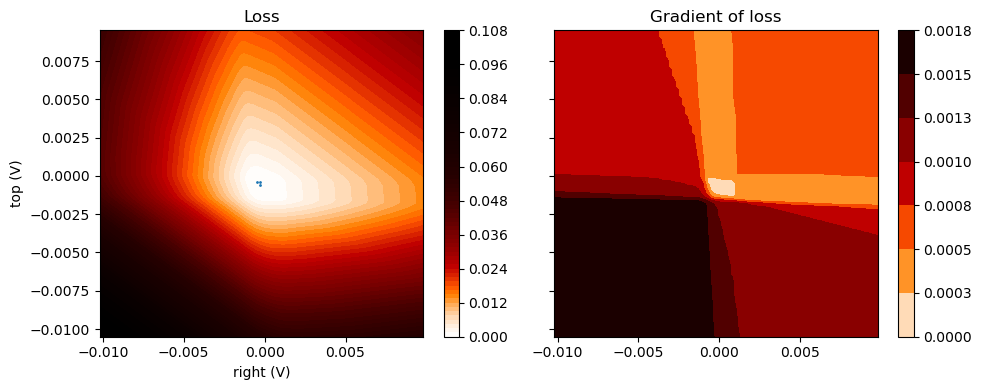

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
normalizer = HistogramNormalize(cost)
cax = ax[0].contourf(right, top, cost, levels=100,
           norm=normalizer,
             cmap = 'gist_heat_r',
             # vmax = 0.0
          # interpolation="bicubic",
          # extent=(left.min(), left.max(), right.min(), right.max()),
          )

ax[0].scatter(zero_points[:, 0], zero_points[:, 1] , s = 1.0)
plt.colorbar(cax, ax=ax[0])
ax[0].set_xlabel('right (V)')
ax[0].set_ylabel('top (V)')
ax[0].set_title('Loss')

gradient = np.gradient(cost)

fulgrad = np.sqrt(gradient[0]**2 + gradient[1]**2)
cax = ax[1].contourf(right, top, fulgrad, cmap = 'gist_heat_r',
                     # vmin = np.amin(fulgrad),
                     # vmax = np.amax(fulgrad) 
                    )
ax[1].set_title('Gradient of loss')
plt.colorbar(cax, ax=ax[1], format='%.4f')
plt.tight_layout()

#### Wavefunction loss

In [18]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [19]:
ci, wf_amp = 50, 1e-4
args = ((system.base_ham, 
        params, 
        system.linear_terms, 
        system.f_params, 
         system.mlwf[order_wavefunctions(pair)]),
        (pair.split('-'), ci, wf_amp)
       )
       

sol2 = minimize(codes.optimization.wavefunction_loss, 
         x0=sol1.x, 
         args=args, 
         method='trust-constr',
         options={
             'initial_tr_radius':1e-3,
             'verbose':2,
         }
        )

[-0.00303348 -0.00303348 -0.00397837  0.00279861]
coupling:1.974e-11
[8.99355777e-07 8.99355835e-07] [[18647.01708491    53.46693364]
 [   53.46693364 18647.01708493]]
[-0.00303349 -0.00303348 -0.00397837  0.00279861]
coupling:1.974e-11
[8.99331744e-07 8.99353118e-07] [[18647.58370735    53.46709159]
 [   53.46740637 18647.06662272]]
[-0.00303348 -0.00303349 -0.00397837  0.00279861]
coupling:1.974e-11
[8.99353059e-07 8.99331802e-07] [[18647.06661958    53.46740629]
 [   53.46709151 18647.58370425]]
[-0.00303348 -0.00303348 -0.00397838  0.00279861]
coupling:1.974e-11
[8.99354617e-07 8.99354628e-07] [[18647.06744482    53.46695443]
 [   53.46695443 18647.06744483]]
[-0.00303348 -0.00303348 -0.00397837  0.00279863]
coupling:1.974e-11
[8.99360941e-07 8.99360979e-07] [[18646.94415037    53.46688056]
 [   53.46688055 18646.94415038]]
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5 

KeyboardInterrupt: 

In [516]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
params['dep_acc_index'] = indices

args = (pair,
        params,
       (system.base_ham, 
        system.linear_terms, 
        system.f_params, 
        system.mlwf[order_wavefunctions(pair)]),
       )


sol2 = minimize(codes.optimization.loss, 
         x0=x0, 
         args=args, 
         method='trust-constr',
         options={'initial_tr_radius':1e-3,
                  'verbose':2,
                 }
        )

NameError: name 'x0' is not defined

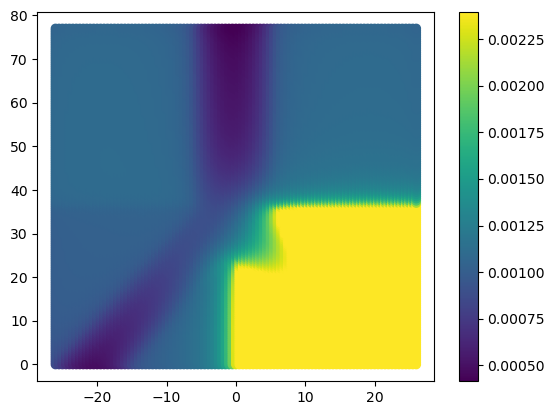

In [357]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/")
from potential import gate_potential

unique_indices = system.site_coords[:, 2] == 0
coords = system.site_coords[unique_indices]
indices = system.site_indices[unique_indices]
voltages = parameters.voltage_dict([-0.00102735,
                                    -0.00413015,
                                    -0.00111647,
                                    0.00354615]),
charges = {}
pot = gate_potential(
    system.poisson_system,
    system.linear_problem,
    coords[:, [0, 1]],
    indices,
    voltages[0],
    {},
    offset=system.offset[[0, 1]],
)

poisson_sites = np.array(list(pot.keys()))

plt.scatter(poisson_sites[:, 0], poisson_sites[:, 1], 
            c = -1*np.array(list(pot.values())), vmax = bands[0])
plt.colorbar();

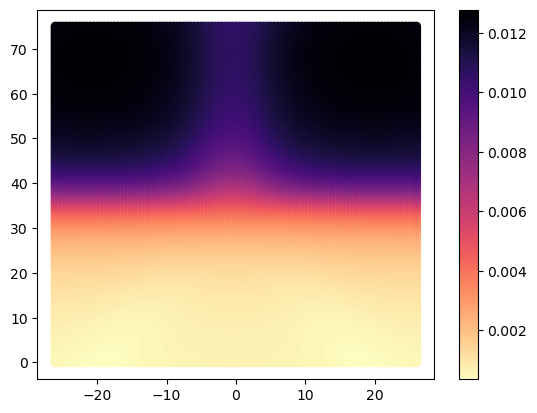

In [26]:
# import sys
# sys.path.append("/home/tinkerer/spin-qubit/")
from potential import gate_potential

unique_indices = system.site_coords[:, 2] == 0
coords = system.site_coords[unique_indices]
indices = system.site_indices[unique_indices]
voltage = sol1.x.copy()
# voltage[0] += +0.0075
# voltage[1] += -0.0050
voltages = parameters.voltage_dict([-0.00058147,
                                    -0.00058213,
                                    -0.01380494,
                                    0.00311198]),
charges = {}
pot = gate_potential(
    system.poisson_system,
    system.linear_problem,
    coords[:, [0, 1]],
    indices,
    voltages[0],
    {},
    offset=system.offset[[0, 1]],
)

poisson_sites = np.array(list(pot.keys()))

plt.scatter(poisson_sites[:, 0], poisson_sites[:, 1], 
            cmap = 'magma_r',
            c = -1*np.array(list(pot.values())))
plt.colorbar();